<a href="https://colab.research.google.com/github/kenken0830/Graphing/blob/main/CLIP_reward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title **setup**

# Git clone
! git clone https://github.com/cedro3/CLIP-Caption-Reward.git
%cd /content/CLIP-Caption-Reward

# Install library
!pip install -r requirements.txt
!pip uninstall -y  torchtext # to bypass pt-lightning issue (https://github.com/PyTorchLightning/pytorch-lightning/issues/6415)
!pip install -e .

# Import library
import torch
import torch.nn as nn
import numpy as np
import json
import captioning.utils.opts as opts
import captioning.models as models
import captioning.utils.misc as utils
import pytorch_lightning as pl
from function import display_pic

# Checkpoint class
class ModelCheckpoint(pl.callbacks.ModelCheckpoint):
    def on_keyboard_interrupt(self, trainer, pl_module):
        # Save model when keyboard interrupt
        filepath = os.path.join(self.dirpath, self.prefix + 'interrupt.ckpt')
        self._save_model(filepath)

# Device and model configurations
device = 'cuda' #@param ["cuda", "cpu"] {allow-input: true}
reward = 'clips_grammar' #@param ["mle", "cider", "clips", "cider_clips", "clips_grammar"] {allow-input: true}

if reward == 'mle':
    cfg = f'./configs/phase1/clipRN50_{reward}.yml'
else:
    cfg = f'./configs/phase2/clipRN50_{reward}.yml'
print("Loading cfg from", cfg)

opt = opts.parse_opt(parse=False, cfg=cfg)


# Doenload pretraied checkpoint
import gdown
if reward == "mle":
  url = "https://drive.google.com/drive/folders/1hfHWDn5iXsdjB63E5zdZBAoRLWHQC3LD"
elif reward == "cider":
  url = "https://drive.google.com/drive/folders/1MnSmCd8HFnBvQq_4K-q4vsVkzEw0OIOs"
elif reward == "clips":
  url = "https://drive.google.com/drive/folders/1toceycN-qilHsbYjKalBLtHJck1acQVe"
elif reward == "cider_clips":
  url = "https://drive.google.com/drive/folders/1toceycN-qilHsbYjKalBLtHJck1acQVe"
elif reward == "clips_grammar":
  url = "https://drive.google.com/drive/folders/1nSX9aS7pPK4-OTHYtsUD_uEkwIQVIV7W"
gdown.download_folder(url, quiet=True, use_cookies=False, output="save/")


# --- Load vocabulary ---
url = "https://drive.google.com/uc?id=1HNRE1MYO9wxmtMHLC8zURraoNFu157Dp"
gdown.download(url, quiet=True, use_cookies=False, output="data/")

dict_json = json.load(open('./data/cocotalk.json'))
print(dict_json.keys())

ix_to_word = dict_json['ix_to_word']
vocab_size = len(ix_to_word)
print('vocab size:', vocab_size)

seq_length = 1
opt.vocab_size = vocab_size
opt.seq_length = seq_length


# --- Load Model checkpoint ---
opt.batch_size = 1
opt.vocab = ix_to_word
# opt.use_grammar = False

model = models.setup(opt)
del opt.vocab

ckpt_path = opt.checkpoint_path + '-last.ckpt'

print("Loading checkpoint from", ckpt_path)
raw_state_dict = torch.load(
    ckpt_path,
    map_location=device)

strict = True

state_dict = raw_state_dict['state_dict']

if '_vocab' in state_dict:
    model.vocab = utils.deserialize(state_dict['_vocab'])
    del state_dict['_vocab']
elif strict:
    raise KeyError
if '_opt' in state_dict:
    saved_model_opt = utils.deserialize(state_dict['_opt'])
    del state_dict['_opt']
    # Make sure the saved opt is compatible with the curren topt
    need_be_same = ["caption_model",
                    "rnn_type", "rnn_size", "num_layers"]
    for checkme in need_be_same:
        if getattr(saved_model_opt, checkme) in ['updown', 'topdown'] and \
                getattr(opt, checkme) in ['updown', 'topdown']:
            continue
        assert getattr(saved_model_opt, checkme) == getattr(
            opt, checkme), "Command line argument and saved model disagree on '%s' " % checkme
elif strict:
    raise KeyError
res = model.load_state_dict(state_dict, strict)
print(res)

model = model.to(device)
model.eval();


# --- Load CLIP image encoder ---
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from timm.models.vision_transformer import resize_pos_embed

clip_model, clip_transform = clip.load("RN50", jit=False, device=device)

preprocess = Compose([
    Resize((448, 448), interpolation=Image.BICUBIC),
    CenterCrop((448, 448)),
    ToTensor()
])

image_mean = torch.Tensor([0.48145466, 0.4578275, 0.40821073]).to(device).reshape(3, 1, 1)
image_std = torch.Tensor([0.26862954, 0.26130258, 0.27577711]).to(device).reshape(3, 1, 1)

num_patches = 196 #600 * 1000 // 32 // 32
pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, clip_model.visual.attnpool.positional_embedding.shape[-1],  device=device),)
pos_embed.weight = resize_pos_embed(clip_model.visual.attnpool.positional_embedding.unsqueeze(0), pos_embed)
clip_model.visual.attnpool.positional_embedding = pos_embed

Cloning into 'CLIP-Caption-Reward'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 192 (delta 1), reused 0 (delta 0), pack-reused 186
Receiving objects: 100% (192/192), 6.02 MiB | 19.96 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/CLIP-Caption-Reward
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.9 MB/s 
     |████████████████████████████████| 1.8 MB 61.1 MB/s 
     |████████████████████████████████| 60 kB 8.4 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 509 kB 72.2 MB/s 
     |████████████████████████████████| 510 kB 73.0 MB/s 
     |████████████████████████████████| 829 kB 64.3 MB/s 
     |████████████████████████████████| 120 kB 55.0 MB/s 
     |████████████████████████████████| 6.6 MB 27.0 MB/s 
     |███████████

100%|███████████████████████████████████████| 256M/256M [00:04<00:00, 63.3MiB/s]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


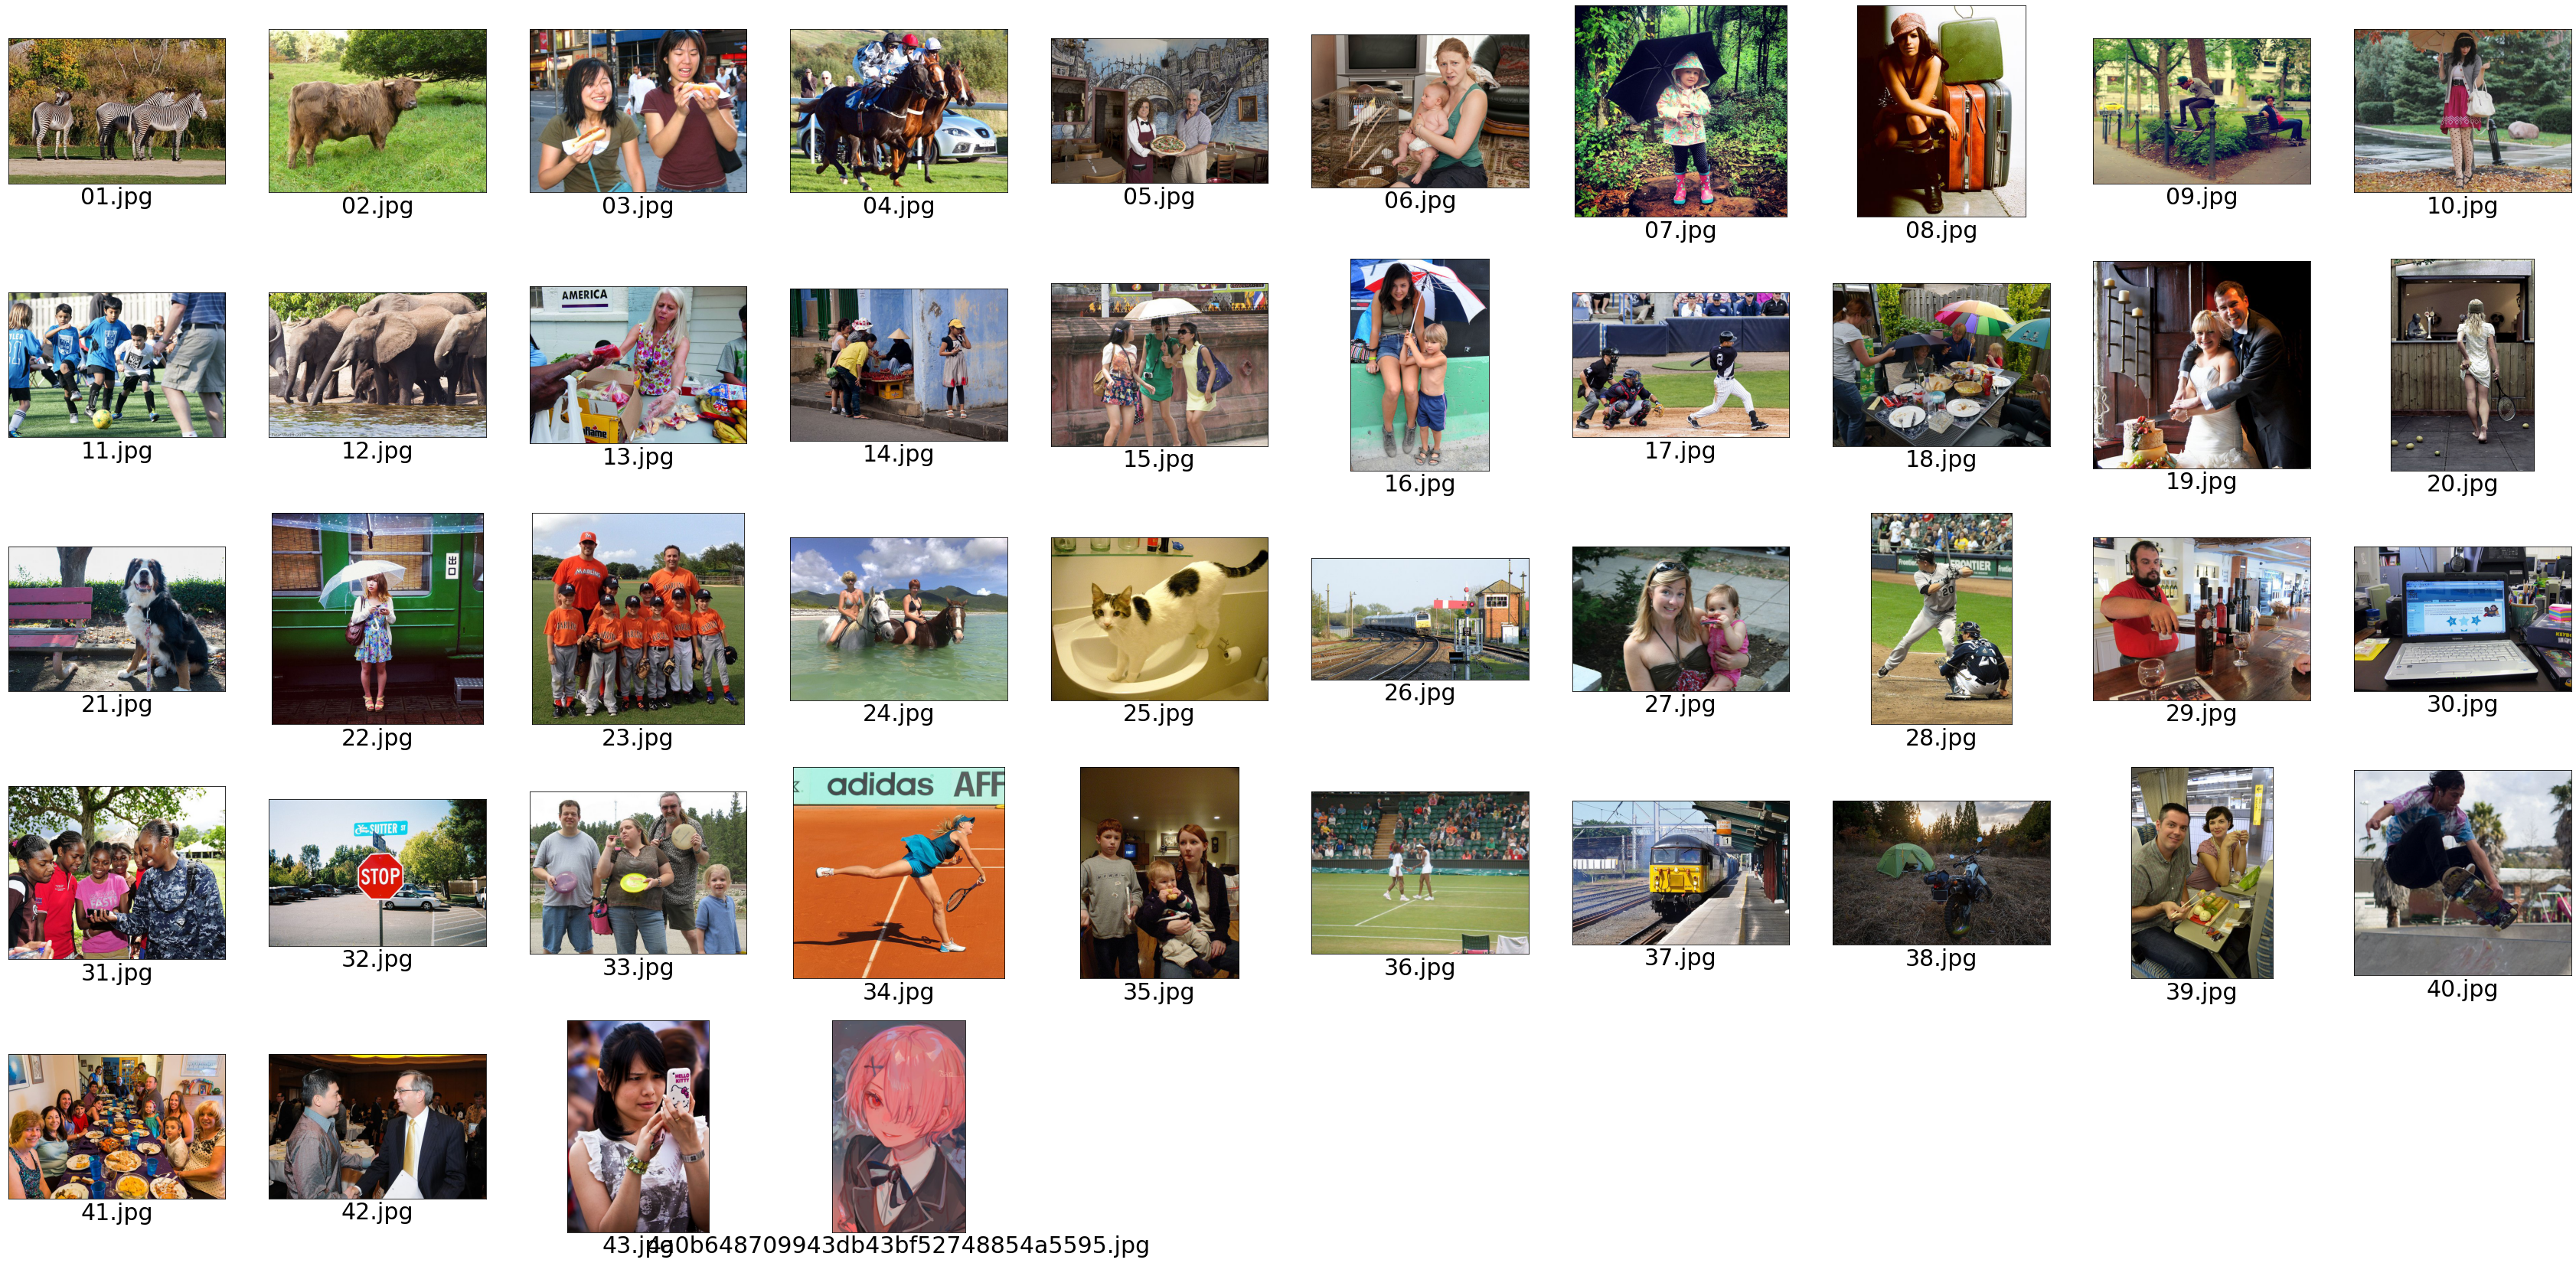

In [3]:
#@title **display sample picture**
display_pic('images')

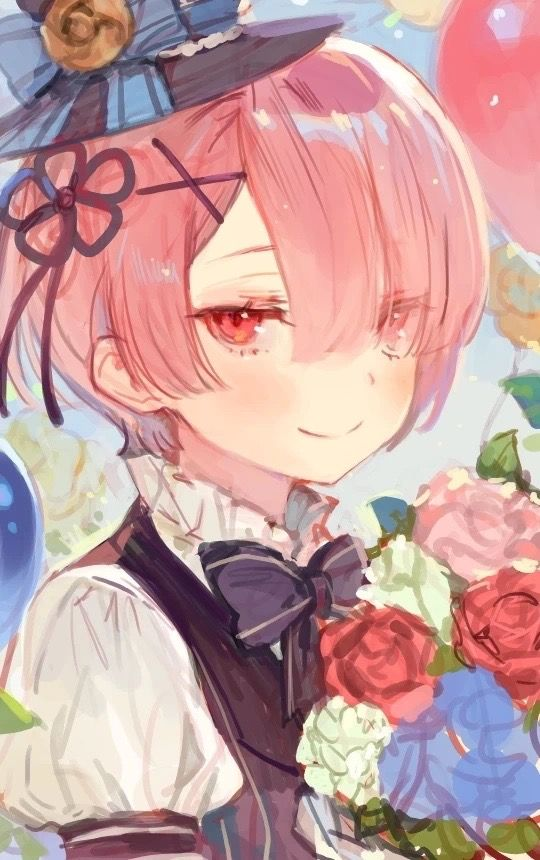

['a young woman wearing a pink makeup with a notebook in the background']


In [6]:
#@title **Generate caption**

# --- Extract visual feature ---
picture = '44.jpg'#@param {type:"string"}
img_path = 'images/'+picture

# display image
from IPython.display import Image as show_imge
from IPython.display import display
display(show_imge(img_path))

with torch.no_grad():
    image = preprocess(Image.open( img_path ).convert("RGB"))
    image = torch.tensor(np.stack([image])).to(device)
    image -= image_mean
    image /= image_std
    
    tmp_att, tmp_fc = clip_model.encode_image(image)
    tmp_att = tmp_att[0].permute(1, 2, 0)
    tmp_fc = tmp_fc[0]
    
    att_feat = tmp_att
    fc_feat = tmp_fc


# --- Generate caption ---
# Inference configurations
eval_kwargs = {}
eval_kwargs.update(vars(opt))

verbose = eval_kwargs.get('verbose', True)
verbose_beam = eval_kwargs.get('verbose_beam', 0)
verbose_loss = eval_kwargs.get('verbose_loss', 1)

# dataset = eval_kwargs.get('dataset', 'coco')
beam_size = eval_kwargs.get('beam_size', 1)
sample_n = eval_kwargs.get('sample_n', 1)
remove_bad_endings = eval_kwargs.get('remove_bad_endings', 0)

with torch.no_grad():
    fc_feats = torch.zeros((1,0)).to(device)
    att_feats = att_feat.view(1, 196, 2048).float().to(device)
    att_masks = None

    # forward the model to also get generated samples for each image
    # Only leave one feature for each image, in case duplicate sample
    tmp_eval_kwargs = eval_kwargs.copy()
    tmp_eval_kwargs.update({'sample_n': 1})
    seq, seq_logprobs = model(
        fc_feats, att_feats, att_masks, opt=tmp_eval_kwargs, mode='sample')
    seq = seq.data

    sents = utils.decode_sequence(model.vocab, seq)

print(sents)